# Differential Privacy

Python 3.9

In [3]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv(os.path.join('dataset', 'infringement_dataset.csv'))
data = data.dropna()

In [5]:
data.head()

,loan_id,infringed,contract_type,gender,has_own_car,has_own_realty,num_children,annual_income,credit_amount,credit_annuity,...,SK_ID_CURR,avg_days_decision,past_avg_amount_annuity,past_avg_amt_application,past_avg_amt_credit,past_loans_approved,past_loans_refused,past_loans_canceled,past_loans_unused,past_loans_total
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,100009.0,719.285714,10051.412143,76741.714286,70137.642857,7.0,0.0,0.0,0.0,7.0
15,100019,0,Cash loans,M,Y,Y,0,157500.0,299772.0,20160.0,...,100019.0,925.000000,10518.615000,84136.500000,104683.500000,1.0,0.0,0.0,0.0,1.0
21,100025,0,Cash loans,F,Y,Y,1,202500.0,1132573.5,37561.5,...,100025.0,731.000000,27645.595714,259795.344375,295425.781875,7.0,1.0,0.0,0.0,8.0
51,100059,0,Cash loans,M,Y,Y,1,540000.0,675000.0,34596.0,...,100059.0,1106.500000,25907.202692,186235.560000,225695.225000,6.0,4.0,8.0,0.0,18.0
66,100078,0,Cash loans,F,Y,Y,0,180000.0,1035000.0,43983.0,...,100078.0,612.727273,24960.538125,403363.636364,422988.136364,4.0,3.0,4.0,0.0,11.0


## functions

In [6]:
def calculate_sensitivity(data, function):
    data = data.to_numpy()
    results = []
    for i in range(len(data)):
        array_prev = data[:i]
        array_pos = data[i+1:]
        data_without = np.concatenate((array_prev, array_pos), axis=None)
        res = np.abs(function(data) - (function(data_without)))
        results.append(res)
    
    return np.max(np.array(results))

In [7]:
def add_noise(data, sensitivity, epsilon):
    return data + np.random.laplace(loc=0, scale=sensitivity/epsilon)

In [8]:
def error(original, predicted):
    return (original - predicted) / original * 100

In [9]:
def count_total (epsilon, infringed=True):
    count = data[data.infringed == infringed].shape[0]
    res = add_noise(count, calculate_sensitivity(data.infringed, len), epsilon)
    print(f"Percentage error: {np.abs(error(count, res))} %")
    return res

In [10]:
def average(variable, infringed=True, epsilon=0.01):
    selected_data = data[data.infringed == infringed][variable]
    mean = selected_data.mean()
    sens1 = calculate_sensitivity(selected_data, np.sum)
    sens2 = calculate_sensitivity(selected_data, len)
    res = add_noise(selected_data.sum(), sens1, epsilon) / add_noise(selected_data.shape[0], sens2, epsilon)
    print(f"Percentage error: {np.abs(error(mean, res))} %")
    return res

## Analysis - 1

### Average age of of people who infringed and don't

In [11]:
def average_age(infringed=True, epsilon=0.01):
    return average('age', infringed, epsilon)

In [12]:
print('Mean age of the people who infringed', average_age())
print('Mean age of the people who not infringed', average_age(infringed=False))

Percentage error: 11.358030842578195 %
Mean age of the people who infringed 32.198003418456935
Percentage error: 0.1622283174899125 %
Mean age of the people who not infringed 37.99361630279948


Ao comparar com as análise feita ao dataset original, observar-se que a média das pessoas que pediram mais empréstimos / cometeram infrações nnos empréstimos, está de acordo com a distribuição das idades das pessoas. Pelo que todas as médias "caem" na classe 30-40 que aparecem em maior quantidade no dataset.

### Percentage poeple < 35

In [14]:
def number_people_by_age(condition, infringed=True, epsilon=0.01):
    selected_data = data.query(f'age {condition} & infringed == {infringed}')['age']
    data_count = len(selected_data)
    sensitivity = 1
    res = add_noise(data_count, calculate_sensitivity(selected_data, len), epsilon) / count_total(epsilon, infringed) * 100
    print(f"Percentage error: {np.abs(error(data_count, res))} %")
    return res

In [16]:
less_35_infringed = number_people_by_age('<30')
less_35_not_infringed = number_people_by_age('<35', infringed=False)
print(f'Percentage people < 35 that infringed', less_35_infringed, '%')
print(f'Percentage people < 35 that not infringed', less_35_not_infringed, '%')

Percentage error: 3.2908990095936654 %
Percentage error: 96.428039750714 %
Percentage error: 0.3524018315535783 %
Percentage error: 99.63669567223174 %
Percentage people < 35 that infringed 18.645632501272857 %
Percentage people < 35 that not infringed 40.41034037766463 %


### Number people > 50

In [23]:
over_60_infringed = number_people_by_age('>50')
over_60_not_infringed = number_people_by_age('>50', infringed=False)

Percentage error: 4.64382454795931 %
Percentage error: 94.9386884583085 %
Percentage error: 0.040554824259387987 %
Percentage error: 99.65477080145781 %


In [24]:
print(f'Percentage of people >50 that infringed', over_60_infringed)
print(f'Percentage of people >50 that not infringed', over_60_not_infringed)

Percentage of people >50 that infringed 9.363426352129272
Percentage of people >50 that not infringed 10.13938156118413


In [25]:
between_infringed = 100 - over_60_infringed - less_35_infringed
between_not_infringed = 100 - over_60_not_infringed - less_35_not_infringed

([<matplotlib.patches.Wedge at 0x1a5448bd760>,
 [Text(0.916615423181791, 0.6081251236261057, '<30'),
  Text(-1.053560745027858, -0.3162431920790471, '30-50'),
  Text(1.0527504316851308, -0.3189302879733613, '>50')],
 [Text(0.4999720490082496, 0.3317046128869667, '18.6%'),
  Text(-0.5746694972879225, -0.17249628658857113, '72.0%'),
  Text(0.5742275081918894, -0.17396197525819707, '9.4%')])

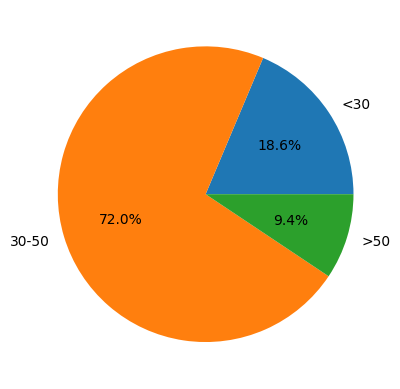

In [26]:
plt.pie([less_35_infringed, between_infringed, over_60_infringed], labels=['<30', '30-50', '>50'], autopct='%1.1f%%')

Verifica-se que a distribuição das classes segue a distribuição original, onde a maior percentagem de pessoas que pediram empréstimos é entre os 30 e os 50 anos.

### Average credit amount

In [93]:
def average_credit_amount(infringed=True, epsilon=0.01):
    return average('credit_amount', infringed, epsilon)

In [94]:
print('Average credit amount of people who infringed', average_credit_amount())
print('Average credit amount of people who not infringed', average_credit_amount(False))

Percentage error: 6.1624240055071615 %
Average credit amount of people who infringed 592151.2055606454
Percentage error: 0.9280605330485149 %
Average credit amount of people who not infringed 608241.2228602935


### Average annual income

In [95]:
def average_income(infringed=True, epsilon=0.01):
    return average('annual_income',infringed, epsilon)

In [96]:
print('Average income of people who infringed', average_income())
print('Average income of people who not infringed', average_income(False))

Percentage error: 111.69963080390927 %
Average income of people who infringed 350599.4864065841
Percentage error: 2.6858824137881325 %
Average income of people who not infringed 164536.49345784672


### Average number family members

In [31]:
def average_family_members(infringed=True, epsilon=0.01):
    return average('num_family_members', infringed, epsilon)

In [33]:
print('Average no.family members of people who infringed', average_family_members())
print('Average no.family members  of people who not infringed', average_family_members(False))

Percentage error: 22.22199978720579 %
Average no.family members of people who infringed 1.897250124181677
Percentage error: 0.4256272836589865 %
Average no.family members  of people who not infringed 2.473808530314866


Observa-se que as médias do nº de pessoas por família é semelhante aos valores obtidos pelo dataset original.

### Percentage female and male who requested loans

https://becominghuman.ai/query-sensitivity-types-and-effects-on-differential-privacy-mechanism-c94fd14b9837

In [103]:
def count_by_gender(infringed=True, epsilon=0.01):
    females = data[(data.gender == 'F') & (data.infringed == infringed)]
    males = data[(data.gender == 'M') & (data.infringed == infringed)]
    count_females = females.shape[0]
    count_males = males.shape[0]
    res_female = add_noise(count_females, calculate_sensitivity(females, len), epsilon) / count_total(epsilon, infringed) * 100
    res_male = add_noise(count_males, calculate_sensitivity(males, len), epsilon) / count_total(epsilon, infringed) * 100

    return res_female, res_male

In [104]:
f, m = count_by_gender()
print(f'Number of females who made loans and were infringed', f)
print(f'Number of males who made loans and were infringed', m)
f, m = count_by_gender(False)
print(f'Number of females who made loans and werent infringed', f)
print(f'Number of males who made loans and werent infringed', m)

Percentage error: 1.2390668883849727 %
Percentage error: 0.03547338678345388 %
Number of females who made loans and were infringed 55.644271288144424
Number of males who made loans and were infringed 44.72973811069526
Percentage error: 0.0015647190162784788 %
Percentage error: 0.04183861598191345 %
Number of females who made loans and werent infringed 66.62537666338713
Number of males who made loans and werent infringed 33.39252091823837


Mais uma vez, observa-se que as médias obtidas são semelhantes às do dataset original.

## Analysis 2 - According to past values

### Average loans 

In [34]:
def average_past_loans(infringed=True, epsilon=0.01):
    return average('past_loans_total', infringed, epsilon)

In [35]:
print('Average loans of people who infringed', average_past_loans())
print('Average loans of people who not infringed', average_past_loans(False))

Percentage error: 11.084137808251663 %
Average loans of people who infringed 4.8397991433833125
Percentage error: 5.270399795126464 %
Average loans of people who not infringed 4.724761834604171


### Average loans approved

In [36]:
def average_loans_approved(infringed=True, epsilon=0.01):
    return average('past_loans_approved', infringed, epsilon)

In [40]:
print('Average loans approved of people who infringed', average_loans_approved())
print('Average loans approved of people who not infringed', average_loans_approved(False))

Percentage error: 23.940452927771112 %
Average loans approved of people who infringed 3.7040557064896467
Percentage error: 0.5045331154146948 %
Average loans approved of people who not infringed 3.207386403414266


Observa-se que as médias são semelhantes às do dataset original, apesar de existirem algumas diferenças, devido ao erro introduzido.

### Average loans refused

In [41]:
def average_loans_refused(infringed=True, epsilon=0.01):
    return average('past_loans_refused', infringed, epsilon)

In [42]:
print('Average loans refused of people who infringed', average_loans_refused())
print('Average loans refused of people who not infringed', average_loans_refused(False))

Percentage error: 77.39782565095018 %
Average loans refused of people who infringed 0.22096556931436617
Percentage error: 9.510519207962997 %
Average loans refused of people who not infringed 0.8558327556573528


Observa-se que as diferenças para os dados originais ainda são significativas, principalmente para as pessoas que cometeram infrações, isto também se deve ao facto do erro ser de 77%.

### Average amount annuity in past loans

In [43]:
def average_loans_amount_annuity(infringed=True, epsilon=0.01):
    return average('past_avg_amount_annuity', infringed, epsilon)

In [44]:
print('Average loans amount annuity of people who infringed', average_loans_amount_annuity())
print('Average loans ammount annuity of people who not infringed', average_loans_amount_annuity(False))

Percentage error: 8.37376360978757 %
Average loans amount annuity of people who infringed 13399.447176371625
Percentage error: 1.3934740993777963 %
Average loans ammount annuity of people who not infringed 15638.204246710224


Observa-se que os valores estão semelhantes aos originais.

### Average amount application

In [45]:
def average_loans_amount_application(infringed=True, epsilon=0.01):
    return average('past_avg_amt_application', infringed, epsilon)

In [46]:
print('Average loans amount application of people who infringed', average_loans_amount_application())
print('Average loans ammount application of people who not infringed', average_loans_amount_application(False))

Percentage error: 48.02270859993485 %
Average loans amount application of people who infringed 236824.3018215088
Percentage error: 16.489181089781194 %
Average loans ammount application of people who not infringed 194098.93886207265


### Average loans canceled

In [27]:
def average_loans_canceled(infringed=True, epsilon=0.01):
    return average('past_loans_canceled', infringed, epsilon)

In [29]:
print('Average loans canceled of people who infringed', average_loans_canceled())
print('Average loans canceled of people who not infringed', average_loans_canceled(False))

Percentage error: 46.78314248138467 %
Average loans canceled of people who infringed 0.7117533061747219
Percentage error: 63.22790235253656 %
Average loans canceled of people who not infringed 1.4303072523459004


Verifica-se que os valores obtidos, são semelhantes aos originais, apesar de terem alguns erro adicionado.

## Conclusão

Ao comparar os valores obtidos com a análise do dataset original, observa-se que nalguns casos, existem um erro significativo nos valores calculados, pelo que pode afetar futuras análises por parte da Dellenture. No entanto, a maioria dos valores seguem os mesmos pradoões que o dataset original.